In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [16]:
class CustomImageDataset(Dataset):
    def __init__(self,img_dir, labels_dir=None, transform=transforms.ToTensor()):
#         self.img_labels = labels_dir
       
        self.img_dir = img_dir
        self.transform = transform
        

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):

        img_path = os.path.join(self.img_dir,str(idx)+'.png')
        img = Image.open(img_path) 
        image = self.transform(img)
        
        return image
    
    
dataset = CustomImageDataset(img_dir = './data/size-500/raster_mod/')
print(next(iter(dataset)).shape)

torch.Size([1, 64, 64])


In [17]:
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

single_entry  = next(iter(train_dataloader))
print(single_entry.shape)

torch.Size([32, 1, 64, 64])


In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 64, 64
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 32, 32
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 16, 16
            nn.ReLU(),
            nn.Conv2d(32, 64, 16) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 16), # -> N, 32, 16, 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 32, 32 (N,16,31,31 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 64, 64  (N,1,63,63)
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.shape[2]==1:
            decoded = self.decoder(x)
            return x, decoded
        else:
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return encoded, decoded

    def test(self,x):
        decoded = self.decoder(x)
        return decoded

In [19]:

# Model Initialization
model = Autoencoder()
 
# Validation using MSE Loss function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [20]:
# Point to training loop video
num_epochs = 50
outputs = []
path = './models_500/'


for epoch in range(num_epochs):
    
    features = []
    for img in train_dataloader:

        feature, recon = model(img)
        features.append(feature)
        loss = criterion(recon, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#   Saving Features at every 10 iteration 
    if epoch%10 == 0:
        torch.save(features, path+'epoch_'+str(epoch)+'.pt')
    
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))
# Saving the final model
torch.save(features, path+'epoch_'+str(epoch)+'.pt')


Epoch:1, Loss:0.1480
Epoch:2, Loss:0.1671
Epoch:3, Loss:0.1509
Epoch:4, Loss:0.0848
Epoch:5, Loss:0.0605
Epoch:6, Loss:0.0551
Epoch:7, Loss:0.0483
Epoch:8, Loss:0.0408
Epoch:9, Loss:0.0349
Epoch:10, Loss:0.0339
Epoch:11, Loss:0.0382
Epoch:12, Loss:0.0310
Epoch:13, Loss:0.0292
Epoch:14, Loss:0.0273
Epoch:15, Loss:0.0250
Epoch:16, Loss:0.0241
Epoch:17, Loss:0.0240
Epoch:18, Loss:0.0249
Epoch:19, Loss:0.0248
Epoch:20, Loss:0.0194
Epoch:21, Loss:0.0195
Epoch:22, Loss:0.0154
Epoch:23, Loss:0.0159
Epoch:24, Loss:0.0145
Epoch:25, Loss:0.0156
Epoch:26, Loss:0.0151
Epoch:27, Loss:0.0142
Epoch:28, Loss:0.0141
Epoch:29, Loss:0.0145
Epoch:30, Loss:0.0124
Epoch:31, Loss:0.0139
Epoch:32, Loss:0.0114
Epoch:33, Loss:0.0127
Epoch:34, Loss:0.0119
Epoch:35, Loss:0.0113
Epoch:36, Loss:0.0106
Epoch:37, Loss:0.0103
Epoch:38, Loss:0.0104
Epoch:39, Loss:0.0097
Epoch:40, Loss:0.0088
Epoch:41, Loss:0.0101
Epoch:42, Loss:0.0087
Epoch:43, Loss:0.0088
Epoch:44, Loss:0.0084
Epoch:45, Loss:0.0090
Epoch:46, Loss:0.00

In [21]:
# torch.save(model.state_dict(),'FinalModel_puzzle_500.pth')

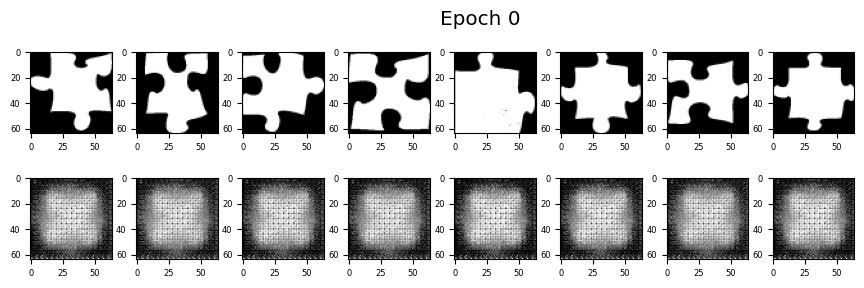

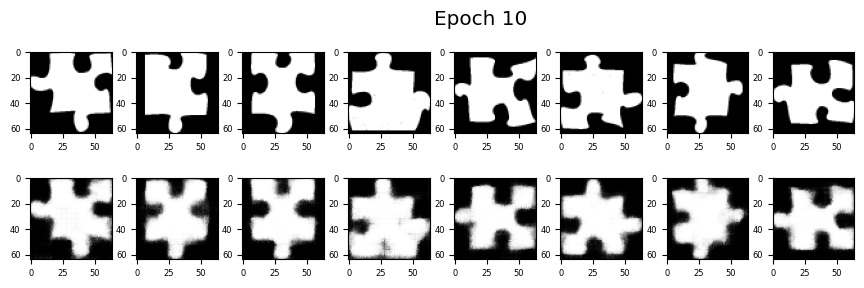

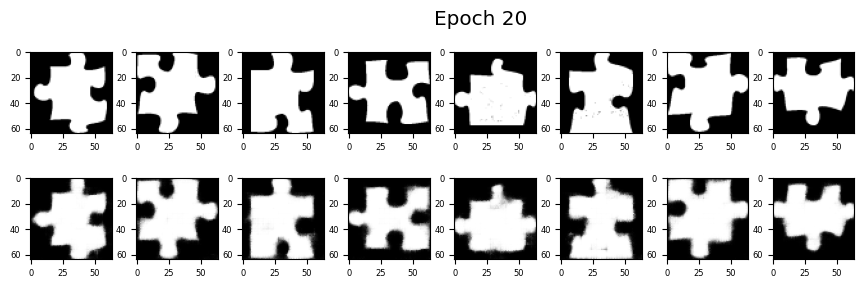

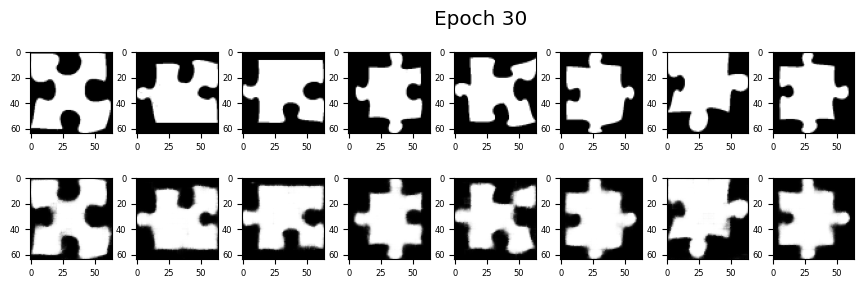

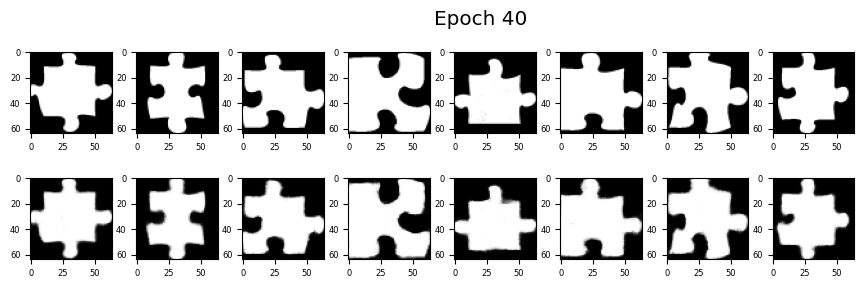

In [8]:
for k in range(0, num_epochs, 10):
    plt.figure(figsize=(12, 3))
    plt.gray()
    plt.rcParams['font.size'] = 12
    plt.suptitle('Epoch '+str(k))
    plt.rcParams['font.size'] = 6
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    plt.subplots_adjust(wspace=0.3, hspace=0.2)
    for i, item in enumerate(imgs):
        if i >= 9: break 
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
     
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        plt.imshow(item[0])
    

In [10]:

# testPoints = torch.load('./models/epoch_9.pt')
# print(len(testPoints[-1][31].detach().numpy()))
# print(len(testPoints))

<Figure size 640x480 with 0 Axes>

In [22]:
test_model =  Autoencoder()
test_model.load_state_dict(torch.load('FinalModel_puzzle_500.pth'))
test_model.eval()
print(test_model)
temp1 = 0
for img in train_dataloader:
    temp1 = img[0][0]
    out1,out2 = test_model(img[0])
    break
# print(out2.shape)


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(16, 16), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(16, 16), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


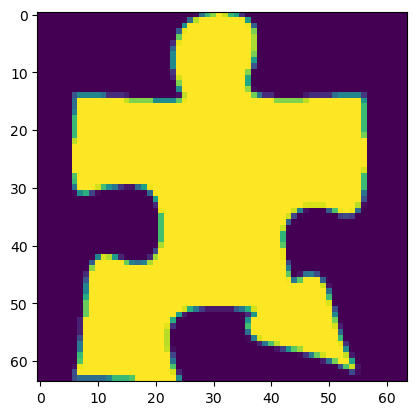

In [23]:
plt.imshow(temp1)

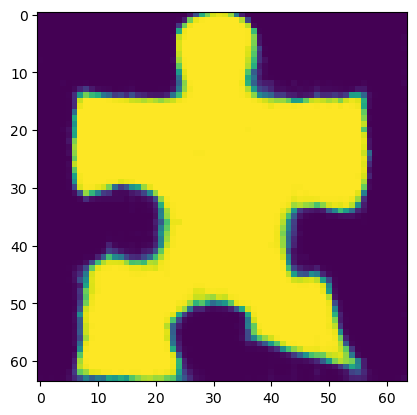

In [24]:
plt.imshow(out2[0].detach().numpy())

In [37]:
## Used to ignore warnings in sklearn
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

In [38]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.cluster import KMeans

In [25]:
testPoints = torch.load('./models_500/epoch_49.pt')
features = torch.cat(testPoints)
# f = torch.stack(testPoints)
f1 = torch.squeeze(features)
data = f1.detach().numpy()

In [16]:
km = KMeans(n_clusters=16, n_init=10)
y_km = km.fit_predict(data)


print(y_km)

[ 6 14  7  4  3  3  3  8  1 12  4  3  7 10 11  1  4 15  6 13 10  1 14 10
  1 15  2 15 13  2  8  8 15 13 15  3 15 15  6 10  7  7  7 15 12 15  4  9
  3  6 10 13  7  4 10  5  3 11  3  4  8  9  9  3  8  5  2 15  8  9  9  5
  4  7  5  6  8 10  2  5 11  2  3  3  7  6  9 12  9 10 14 12 15  1 10  9
  9  4  7  6 15  0 11  0  4  9  1 12  3  7  8  4 13  4 14  6 13 13  1 12
  0  7  8  5 15 12  9  4 13  2 13  7 13  6  3  0 13  8  1  4 14 14 12  2
  6  0  3  8  0  9 10 13 10  6 13  8  0  8  9  5  6  9  5  7 14  7  8  0
 11  8  2  0 14  3 15 15 11  7 14  0  0 13  2 15 13 10 14  5  0  6  3  4
 11  7  5 12 11  0 10 13 15  4 11  8  0  1  7 15  9 10 14  2 13  7  9 13
  7  0  9  0 10  5  6 14  1  8 15  4  1 12  3 14 11 14  6  1  9  7  6  4
 11  8  8 13  5 12  5  4  7 11  8  5  6 13  1  4 12  9  6 13 10  9 13  5
 12  3  8 15  9  6  4  7  4  8  8 14  1  3  7  3  5  0  1  1  1  1  8  6
  4  6 10  1 10  3  1  2  6  2  8 15  1  2  9  9  3 14  3  5  3 15  8 15
 12  0  0  3  3  9  1  9 14  1  3  0  0  9  3  8  8

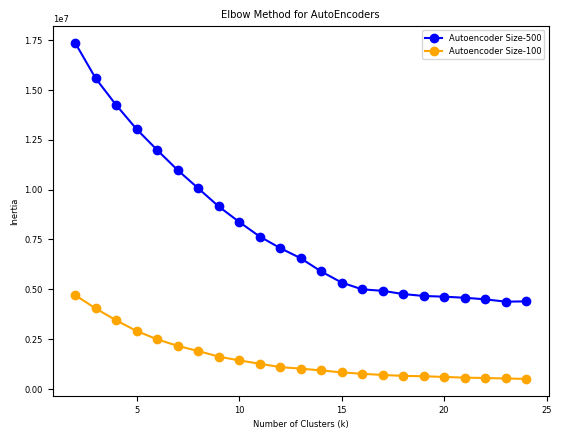

In [21]:
testPoints = torch.load('./models_500/epoch_49.pt')
features = torch.cat(testPoints)
# f = torch.stack(testPoints)
f1 = torch.squeeze(features)
data1 = f1.detach().numpy()

testPoints = torch.load('./models/epoch_49.pt')
features = torch.cat(testPoints)
# f = torch.stack(testPoints)
f1 = torch.squeeze(features)
data2 = f1.detach().numpy()


k_values = range(2, 25)  # Range of k values to try
inertias1 = []
inertias2 = []

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data1)
    inertias1.append(kmeans.inertia_)
    kmeans.fit(data2)
    inertias2.append(kmeans.inertia_)
#     label = str(i)+' Features'
    
# Plot the elbow curve
plt.plot(k_values, inertias1, 'bo-',c='b',label = 'Autoencoder Size-500')
plt.plot(k_values, inertias2, 'bo-',c='orange', label = 'Autoencoder Size-100')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.legend()
plt.title('Elbow Method for AutoEncoders')
# plt.show()
plt.savefig('./Autoencoder Elbow Method.png' )

[ 1  1  0 11  7  3  9  6  8 10 12 11  9 12  5  8 12  7  9  3  4  5  5 11
  1  0  6 12  6 10 10 10  4  3  8  2  8  1  7  0  1  5  9  1  9  8  5  7
 -1 12  6  8  6 11 10  4 10 -1 12 10 10  3  3  0 12  1  4  4  8  8  8  8
  2  6 10  7  1  1  3  9 11  8  8 12  1  5 -1  2  0  0  1 11  0  8 -1  3
  6  9 11  8  2 10  2  0  0  8  8  0]


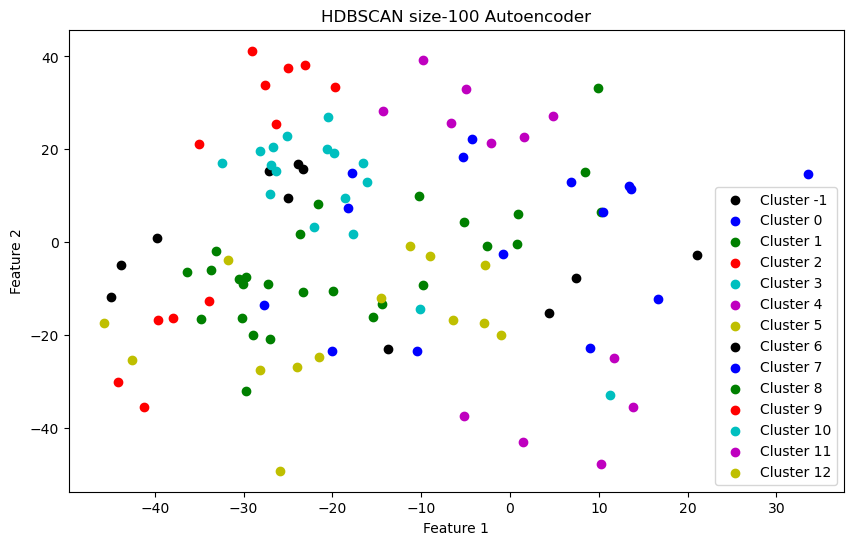

In [35]:
import hdbscan
import numpy as np
testPoints = torch.load('./models_500/epoch_49.pt')
features = torch.cat(testPoints)
# f = torch.stack(testPoints)
f1 = torch.squeeze(features)
data1 = f1.detach().numpy()

testPoints = torch.load('./models/epoch_49.pt')
features = torch.cat(testPoints)
# f = torch.stack(testPoints)
f1 = torch.squeeze(features)
data2 = f1.detach().numpy()

hdbscan = hdbscan.HDBSCAN(min_samples = 2)
labels = hdbscan.fit_predict(data2)
# hdbscan.condensed_tree_.plot(select_clusters=True)
# np.unique(labels)
clusters = labels
print(clusters)  

unique_labels = np.unique(labels)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Add more colors if needed
plt.figure(figsize=(10,6))
for label in unique_labels:
    if label == -1:
        # Noise points are plotted in black
        color = 'k'
    else:
        color = colors[label % len(colors)]
    
    # Plot points of the current cluster
    cluster_points = data2[clusters == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=color, label=f'Cluster {label}')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('HDBSCAN size-100 Autoencoder')
plt.legend()
plt.savefig('HDBScan (Autoencoder 100).png')


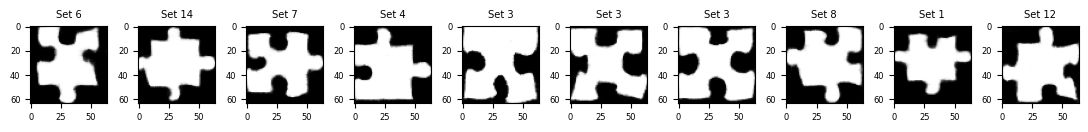

In [18]:
# print(Y)
plt.figure(figsize=(15, 1))
plt.gray()
for i in range(10):
    
    t1 = torch.tensor(data[i]).unsqueeze(1)
    t2  = t1.unsqueeze(2)
    x,y = test_model(t2)
    img = y[0].detach().numpy()

    plt.subplots_adjust(wspace=0.3)  
    plt.subplot(1, 11, i+1)
    plt.gca().set_title('Set '+str(y_km[i]))
    plt.imshow(img)

    
    

In [42]:
testPoints = torch.load('./models_500/epoch_49.pt')
features = torch.cat(testPoints)
# f = torch.stack(testPoints)
f1 = torch.squeeze(features)
data = f1.detach().numpy()

km = KMeans(n_clusters=16, n_init=10)
y_km = km.fit_predict(data)
AE_cluster = []
for i in range(16):
    AE_cluster.append(list(y_km).count(i))
print(AE_cluster)

[34, 32, 27, 40, 24, 28, 35, 35, 36, 33, 41, 26, 36, 38, 29, 26]


In [45]:
from sklearn.cluster import KMeans
import numpy as np
import json
import cv2
import os


ks = [3, 5, 7, 10, 25, 40, 60, 80, 108]
pcaPath = '.\\data\\size-500\\PCA\\PCA_'
os.environ['OMP_NUM_THREADS'] = '1'

no_clusters = 16

#for i in ks:
i = 170
# Load the features from the file
filename = pcaPath + 'features_' + str(i) + '.txt'
with open(filename, 'r') as f:
    features = np.array(json.load(f)) 

# Perform K-means clustering
kmeans = KMeans(n_clusters=no_clusters, n_init=10)  # Specify the desired number of clusters
clusters = kmeans.fit_predict(features)

print("Cluster labels for Principal components =", i)
PCA_cluster = []
for i in range(16):
    PCA_cluster.append(list(clusters).count(i))
print(PCA_cluster)

Cluster labels for Principal components = 170
[28, 24, 36, 29, 40, 26, 41, 38, 35, 35, 33, 34, 27, 26, 36, 32]


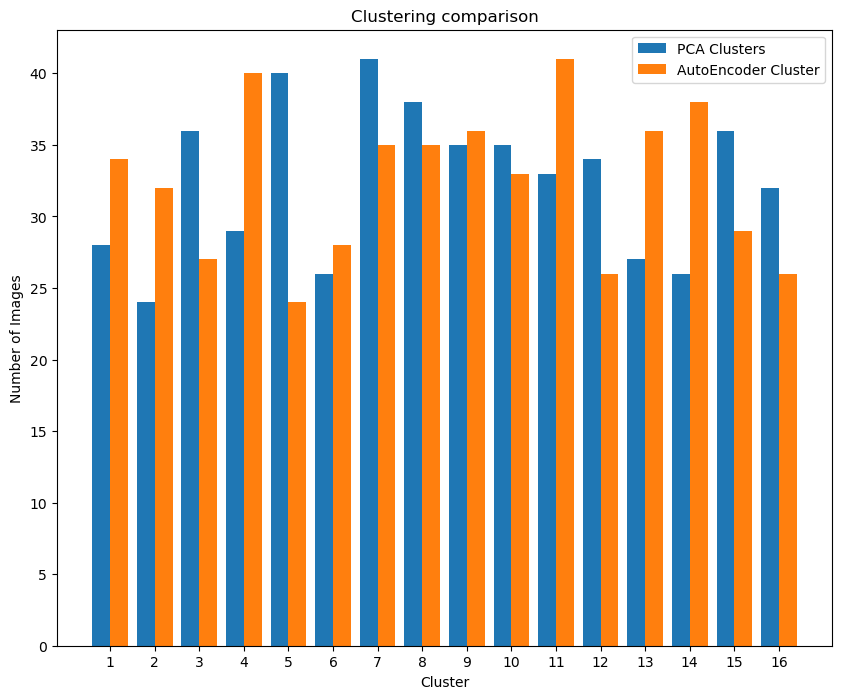

In [52]:
plt.figure(figsize=(10,8))
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Group A','Group B','Group C','Group D']
  
X_axis = np.arange(1,17)
  
plt.bar(X_axis-0.2, PCA_cluster, 0.4, label = 'PCA Clusters')
plt.bar(X_axis+0.2, AE_cluster, 0.4, label = 'AutoEncoder Cluster')
  
plt.xticks(X_axis)
plt.xlabel("Cluster")
plt.ylabel("Number of Images")
plt.title("Clustering comparison")
plt.legend()
plt.savefig('Bar graph.png')